# Real Data Example - 01
In this example, we are going to use a sample data set, which provides monthly 
air temperature and remap it into two new time axis: one with weekly, 
and another with yearly temporal resolution.

## Importing Data
We are going to use the "RASM" data set that you could load using `xarray`. Within that data
set, we will work with `Tair` variable, or air temperature.

In [51]:
import xarray as xr
monthly_air_temperature = xr.tutorial.load_dataset("rasm").Tair

Let's get acquainted with our data set a bit:

In [52]:
print("Data Shape: ", monthly_air_temperature.shape)
print("Air Temperature Attributes:")
for k, v in monthly_air_temperature.attrs.items():
    print("%15s: %s" % (k, str(v)))

Data Shape:  (36, 205, 275)
Air Temperature Attributes:
          units: C
      long_name: Surface air temperature
 type_preferred: double
       time_rep: instantaneous


As you can see, the dat shape is `(36, 205, 275)`. If you examin the data more, you would
find out that the first dimension is time, the second is `y`, and the third is `x`.
Lets now check the time axis:

In [53]:
time_axis = monthly_air_temperature["time"]
nTime = time_axis.size
print("size/length of time axis: ", nTime)
print("First Three Time Values: \n", time_axis.values[:3])
print("Last Three Time Values: \n", time_axis.values[-3:])

size/length of time axis:  36
First Three Time Values: 
 [cftime.DatetimeNoLeap(1980-09-16 12:00:00)
 cftime.DatetimeNoLeap(1980-10-17 00:00:00)
 cftime.DatetimeNoLeap(1980-11-16 12:00:00)]
Last Three Time Values: 
 [cftime.DatetimeNoLeap(1983-06-16 12:00:00)
 cftime.DatetimeNoLeap(1983-07-17 00:00:00)
 cftime.DatetimeNoLeap(1983-08-17 00:00:00)]


as you can see this data set contains monthly temperature, starting from September, 1980,
going for 36 months (3 years), and ending on August, 1983. Let's plot the time series for 
one location:

<BarContainer object of 36 artists>

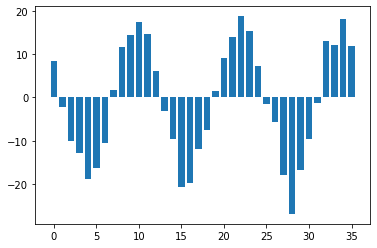

In [54]:
import numpy as np
from matplotlib import pyplot as plt
#matplotlib inline

iy = 20
ix = 200
plt.bar(np.arange(nTime), monthly_air_temperature[:, iy, ix])

## Calculating Weekly Average using `AxisUtilities`
As you have learned in previous notebooks, in order to perform the remapping, we need to
perform the follow four steps:

0. Create source axis object,
1. Create destination axis object,
2. Create a remapping object, and finally
3. Perform the remapping

*NOTE* if you haven't read through the tutorial notebooks yet, perhaps now it's a good
time to have a look at them.

### Creating source axis
As seen above, the source data covers 36 months of data starting with September of 1980 and
ending on August of 1983.
You can use one of the available utilities to easily create the source axis:

In [55]:
from axisutilities import MonthlyTimeAxis
monthly_axis = MonthlyTimeAxis(
    start_year=1980,
    start_month=9,
    end_year=1983,
    end_month=8
)
print("source axis: \n", monthly_axis)

source axis: 
 <timeaxis.TimeAxis>

  > nelem:
	36
  > lower_bound:
	[336614400000000 ... 428544000000000]
  > upper_bound:
	[339206400000000 ... 431222400000000]
  > data_ticks:
	[337910400000000 ... 429883200000000]
  > fraction:
	[0.5 ... 0.5]
  > binding:
	middle


### Creating destination axis
Lets create a destination axis, with each element representing one week rather than a month.
Our destination axis starts on September 1st, 1980, and has 156 week/elements in it:

In [56]:
from datetime import date
from axisutilities import WeeklyTimeAxis
weekly_axis = WeeklyTimeAxis(
    start_date=date(1980, 9, 1),  # Starting the destination axis on Sep. 1st, 1980
    n_interval=156  # 156 weeks (3 years is approximate 3x52=156 week)
)

print("Destination Axis: \n", weekly_axis)

Destination Axis: 
 <timeaxis.TimeAxis>

  > nelem:
	156
  > lower_bound:
	[336614400000000 ... 430358400000000]
  > upper_bound:
	[337219200000000 ... 430963200000000]
  > data_ticks:
	[336916800000000 ... 430660800000000]
  > fraction:
	[0.5 ... 0.5]
  > binding:
	middle


### Creating a remapper
The remapper could be created as follows:

In [57]:
from axisutilities import AxisRemapper
monthly_to_weekly_remapper = AxisRemapper(
    from_axis=monthly_axis, 
    to_axis=weekly_axis,
    assure_no_bound_mismatch=False
)

Note that since the source and destination matrix do not cover exactly the same period 
(156 week is a few days shorter than 3 years), we need to inform the remapper that we are
aware of this mismatch and we do still want to perform this conversion or remapping. 
That's the reason for passing `assure_no_bound_mismatch` parameter and setting it to
`False`. If the source and destination axis cover the exact period, there is no need to
pass that parameter.

### Calculating the weekly average
Now that we have created the remapper we can easily remap the data from monthly axis to
weekly axis:

In [58]:
weekly_air_temperature = monthly_to_weekly_remapper.average(monthly_air_temperature)

/Users/mabouali/NCAR/GitHub/coderepocenter/AxisUtilities/axisutilities/axisremapper.py:273: RuntimeWarning: divide by zero encountered in reciprocal
  inverse_sum_effective_weights = np.reciprocal(weights * non_nan_mask)
/Users/mabouali/NCAR/GitHub/coderepocenter/AxisUtilities/axisutilities/axisremapper.py:276: RuntimeWarning: invalid value encountered in multiply
  np.multiply(weights * from_data_copy, inverse_sum_effective_weights),


Let's plot the time series for the same location as before:

<BarContainer object of 156 artists>

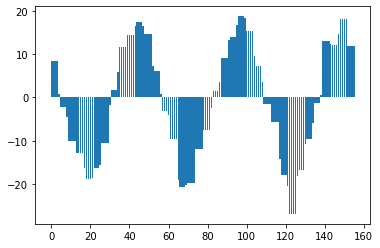

In [59]:
plt.bar(np.arange(weekly_axis.nelem), weekly_air_temperature[:, iy, ix])

Let's overlay the two plots and have a look:

<BarContainer object of 156 artists>

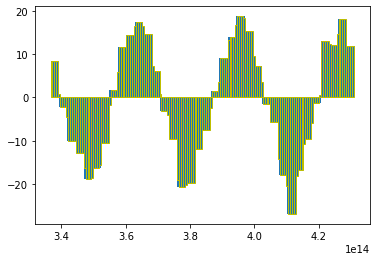

In [60]:
monthly_data_ticks = monthly_axis.data_ticks.reshape((-1,))
monthly_bar_widths = (monthly_axis.upper_bound - monthly_axis.lower_bound).reshape((-1, ))
plt.bar(
    x=monthly_data_ticks,
    height=monthly_air_temperature[:, iy, ix],
    width=monthly_bar_widths
)

weekly_data_ticks = weekly_axis.data_ticks.reshape((-1, ))
weekly_bar_widths = (weekly_axis.upper_bound - weekly_axis.lower_bound).reshape((-1,))
plt.bar(
    x = weekly_data_ticks,
    height=weekly_air_temperature[:, iy, ix],
    width=weekly_bar_widths,
    edgecolor='y',
    facecolor=None
)

## Calculating Yearly averages
The same four steps needs to be followed to calculate yearly averages.

### Creating source axis
since the data has not changed, we could use the same source axis as before. So there is
no need to recreate it here.

### Creating Yearly axis:
Since, 1980 and 1983 are only partially covered in this data set, we are going to create
a yearly axis covering only 1981 and 1982.

In [61]:
from axisutilities import YearlyTimeAxis
yearly_axis = YearlyTimeAxis(
    start_year = 1981,
    end_year = 1983 
)

print("Yearly Axis: \n", yearly_axis)
print("nelem (n years): ", yearly_axis.nelem)

Yearly Axis: 
 <timeaxis.TimeAxis>

  > nelem:
	2
  > lower_bound:
	[347155200000000 ... 378691200000000]
  > upper_bound:
	[378691200000000 ... 410227200000000]
  > data_ticks:
	[362923200000000 ... 394459200000000]
  > fraction:
	[0.5 ... 0.5]
  > binding:
	middle
nelem (n years):  2


### Creating a yearly remapper
As usual, the remapper is created as follows:

In [62]:
monthly_to_yearly_remapper = AxisRemapper(
    from_axis=monthly_axis,
    to_axis=yearly_axis,
    assure_no_bound_mismatch=False
)

### Calculating yearly average
Now that we have the remapper, it is easy to calculate the remapper.

In [63]:
yearly_air_temperature = monthly_to_yearly_remapper.average(monthly_air_temperature)


Now as before, lets create a plot

<BarContainer object of 2 artists>

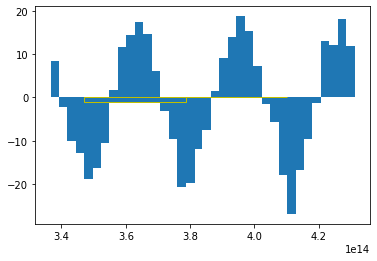

In [64]:
plt.bar(
    x=monthly_data_ticks,
    height=monthly_air_temperature[:, iy, ix],
    width=monthly_bar_widths
)

yearly_data_ticks = yearly_axis.data_ticks.reshape((-1, ))
yearly_bar_widths = (yearly_axis.upper_bound - yearly_axis.lower_bound).reshape((-1,))
plt.bar(
    x = yearly_data_ticks,
    height=yearly_air_temperature[:, iy, ix],
    width=yearly_bar_widths,
    edgecolor='y',
    facecolor=None
)

*NOTES*: 
- You could perform the same operations using other packages as well. Some would be
easier; and some may be more difficult. However, `AxisUtilities` atempts to avoid 
recomputing many of the operations, once it is applied to more than one data field, or
when it is used more than one time. For example, you could easily filter and group the
data by the year to calculate yearly average. However, these operations, i.e. filtering 
and grouping, would be performed over and over as you apply the same operation on the
new data field.
- The calculation performed by `AxisUtilities` is a bit different than other packages,
particularly for the average calculations. If the source and the destination axis cover
exactly the same interval, the area under the curve is preserved. While some other
packages, perform regular iterpolation. So know the difference.

## Surfae plots
Let's create a surface plot for one of the time indices:

In [65]:
fraction = 0.5

### Original Data

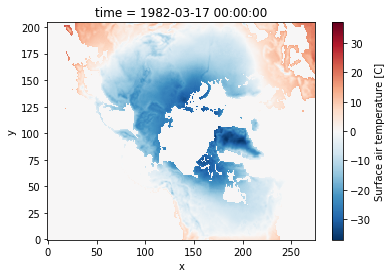

In [66]:
monthly_air_temperature\
    .isel(time=int(monthly_air_temperature.shape[0]*fraction))\
    .plot()


### Weekly data

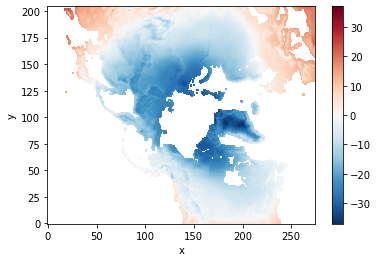

In [67]:
weekly_air_temperature_xr = xr.DataArray(
    data=weekly_air_temperature,
    dims=["time", "y", "x"]
)
weekly_air_temperature_xr\
    .isel(time=int(weekly_air_temperature_xr.shape[0]*fraction))\
    .plot()

### Yearly Data

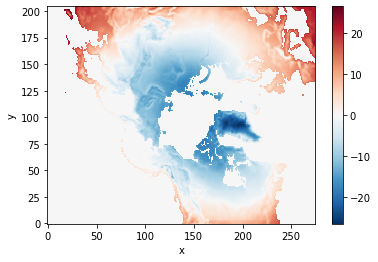

In [68]:
Yearly_air_temperature_xr = xr.DataArray(
    data=yearly_air_temperature,
    dims=["time", "y", "x"]
)
Yearly_air_temperature_xr\
    .isel(time=0)\
    .plot()


